In [1]:
from super_gradients.training import Trainer

CHECKPOINT_DIR = 'checkpoints'
trainer = Trainer(experiment_name='my_first_yolonas_run', ckpt_root_dir=CHECKPOINT_DIR)

[2024-12-07 18:56:32] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into C:\Users\jcw\sg_logs\console.log


W1207 18:56:32.229795 15404 torch\distributed\elastic\multiprocessing\redirects.py:28] NOTE: Redirects are currently not supported in Windows or MacOs.
[2024-12-07 18:56:34] WARNING - env_sanity_check.py - Failed to verify operating system: Deci officially supports only Linux kernels. Some features may not work as expected.


In [2]:
from super_gradients.training import dataloaders
from super_gradients.training.dataloaders.dataloaders import coco_detection_yolo_format_train, coco_detection_yolo_format_val

In [3]:
dataset_params = {
    'data_dir':'./data',
    'train_images_dir':'images/train',
    'train_labels_dir':'labels/train',
    'val_images_dir':'images/val',
    'val_labels_dir':'labels/val',

    'classes': ['belt', 'sunglasses', 'boot', 'cowboy_hat', 'jacket']
}

In [4]:
from IPython.display import clear_output

train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['train_images_dir'],
        'labels_dir': dataset_params['train_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': dataset_params['data_dir'],
        'images_dir': dataset_params['val_images_dir'],
        'labels_dir': dataset_params['val_labels_dir'],
        'classes': dataset_params['classes']
    },
    dataloader_params={
        'batch_size':16,
        'num_workers':2
    }
)



clear_output()

In [5]:
train_data.dataset.transforms

Indexing dataset annotations: 100%|██████████| 247/247 [00:00<00:00, 7296.75it/s]


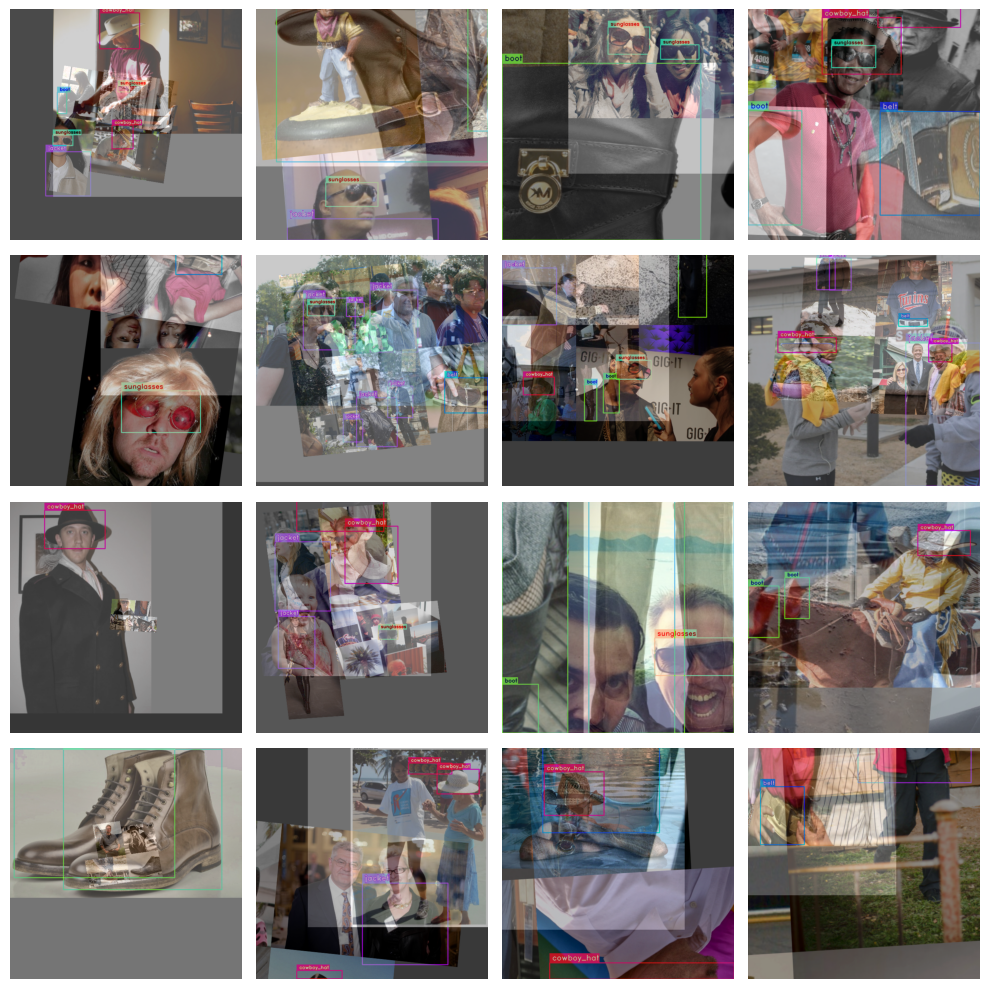

In [6]:
train_data.dataset.plot()

In [7]:
from super_gradients.training import models
model = models.get('yolo_nas_m',
                   num_classes=len(dataset_params['classes']),
                   pretrained_weights="coco"
                   )

[2024-12-07 18:56:38] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-12-07 18:56:38] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-12-07 18:56:38] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_m


In [8]:
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import PPYoloEPostPredictionCallback

train_params = {
    # ENABLING SILENT MODE
    'silent_mode': True,
    "average_best_models":True,
    "warmup_mode": "linear_epoch_step",
    "warmup_initial_lr": 1e-6,
    "lr_warmup_epochs": 3,
    "initial_lr": 5e-4,
    "lr_mode": "cosine",
    "cosine_final_lr_ratio": 0.1,
    "optimizer": "Adam",
    "optimizer_params": {"weight_decay": 0.0001},
    "zero_weight_decay_on_bias_and_bn": True,
    "ema": True,
    "ema_params": {"decay": 0.9, "decay_type": "threshold"},
    # ONLY TRAINING FOR 10 EPOCHS FOR THIS EXAMPLE NOTEBOOK
    "max_epochs": 20,
    "mixed_precision": True,
    "loss": PPYoloELoss(
        use_static_assigner=False,
        # NOTE: num_classes needs to be defined here
        num_classes=len(dataset_params['classes']),
        reg_max=16
    ),
    "valid_metrics_list": [
        DetectionMetrics_050(
            score_thres=0.1,
            top_k_predictions=300,
            # NOTE: num_classes needs to be defined here
            num_cls=len(dataset_params['classes']),
            normalize_targets=True,
            post_prediction_callback=PPYoloEPostPredictionCallback(
                score_threshold=0.01,
                nms_top_k=1000,
                max_predictions=300,
                nms_threshold=0.7
            )
        )
    ],
    "metric_to_watch": 'mAP@0.50'
}

In [ ]:
trainer.train(model=model,
              training_params=train_params,
              train_loader=train_data,
              valid_loader=val_data)

[2024-12-07 18:56:38] INFO - sg_trainer.py - Starting a new run with `run_id=RUN_20241207_185638_888995`
[2024-12-07 18:56:38] INFO - sg_trainer.py - Checkpoints directory: checkpoints\my_first_yolonas_run\RUN_20241207_185638_888995
[2024-12-07 18:56:38] INFO - sg_trainer.py - Using EMA with params {'decay': 0.9, 'decay_type': 'threshold'}
c:\data\annaconda\conda\envs\dl\lib\site-packages\super_gradients\common\registry\registry.py:72: DeprecationWarning: Object name `linear_epoch_step` is now deprecated. Please replace it with `LinearEpochLRWarmup`.
  warnings.warn(f"Object name `{name}` is now deprecated. Please replace it with `{deprecated_names[name]}`.", DeprecationWarning)
c:\data\annaconda\conda\envs\dl\lib\site-packages\super_gradients\training\utils\optimizer_utils.py:108: DeprecationWarning: initialize_param_groups and update_param_groups usages are deprecated since 3.4.0, will be removed in 3.5.0 and have no effect. 
 Assign different learning rates by passing a mapping of l

The console stream is now moved to checkpoints\my_first_yolonas_run\RUN_20241207_185638_888995/console_Dec07_18_56_38.txt


[2024-12-07 18:57:00] INFO - sg_trainer_utils.py - TRAINING PARAMETERS:
    - Mode:                         Single GPU
    - Number of GPUs:               1          (1 available on the machine)
    - Full dataset size:            8911       (len(train_set))
    - Batch size per GPU:           16         (batch_size)
    - Batch Accumulate:             1          (batch_accumulate)
    - Total batch size:             16         (num_gpus * batch_size)
    - Effective Batch size:         16         (num_gpus * batch_size * batch_accumulate)
    - Iterations per epoch:         556        (len(train_loader))
    - Gradient updates per epoch:   556        (len(train_loader) / batch_accumulate)
    - Model: YoloNAS_M  (51.13M parameters, 51.13M optimized)
    - Learning Rates and Weight Decays:
      - default: (51.13M parameters). LR: 0.0005 (51.13M parameters) WD: 0.0, (72.22K parameters), WD: 0.0001, (51.06M parameters)

c:\data\annaconda\conda\envs\dl\lib\site-packages\super_gradients\t

In [ ]:
from super_gradients.training import models
best_model = models.get('yolo_nas_m',
                        num_classes=len(dataset_params['classes']),
                        checkpoint_path=r"C:\data\program\python\CowBoy\super-gradients\train\checkpoints\my_first_yolonas_run\RUN_20241207_124235_369031\average_model.pth")

In [ ]:
img_url = r'C:\data\program\python\CowBoy\super-gradients\train\data\images\val\02be6fdd7949043b.jpg'
best_model.predict(img_url).show()
